In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import csv
import math

print("Libraries imported successfully.")

Libraries imported successfully.


## Parameter Setup

Set fixed Drake parameters and define ranges for sweep variables ($f_l$ and $f_i$).

In [2]:
# ===== Fixed Drake Parameters =====
t_star = 5.0e6  # stellar lifetime for O-stars (years); G-stars live ~10 Gy but we use O-star timescale for comparison
fp = 1.0        # fraction with planets (optimistic: all stars)
ne = 0.1        # planets per star in habitable zone
fc = 0.1        # fraction developing civilization
L = 1.0e5       # civilization lifetime (years)
n_stars = 2     # number of stars in sample (O-stars in shell)

# Note: For G-stars, N_stars would be ~500k (estimated from G_star_results.json)
# But we compute per-star probability first, then scale.

print("Fixed Parameters:")
print(f"  t_star = {t_star:.2e} yr (stellar lifetime)")
print(f"  fp = {fp} (fraction with planets)")
print(f"  ne = {ne} (planets per star in habitable zone)")
print(f"  fc = {fc} (fraction developing civilization)")
print(f"  L = {L:.2e} yr (civilization lifetime)")
print(f"  n_stars = {n_stars} (sample size for at-least-one probability)")

Fixed Parameters:
  t_star = 5.00e+06 yr (stellar lifetime)
  fp = 1.0 (fraction with planets)
  ne = 0.1 (planets per star in habitable zone)
  fc = 0.1 (fraction developing civilization)
  L = 1.00e+05 yr (civilization lifetime)
  n_stars = 2 (sample size for at-least-one probability)


## Sweep Parameters

Define log-spaced ranges for $f_l$ (fraction of habitable planets with life) and $f_i$ (fraction with intelligence).

In [3]:
# ===== Sweep Ranges (log-spaced) =====
fl_values = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-6]
fi_values = [1e-0, 1e-1, 1e-2, 1e-3, 1e-6]

print(f"f_l sweep ({len(fl_values)} values): {fl_values}")
print(f"f_i sweep ({len(fi_values)} values): {fi_values}")
print(f"Total grid points: {len(fl_values) * len(fi_values)}")

f_l sweep (6 values): [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-06]
f_i sweep (5 values): [1.0, 0.1, 0.01, 0.001, 1e-06]
Total grid points: 30


## Compute Sweep

For each $(f_l, f_i)$ pair, compute:
- Per-star probability: $p = f_p \times n_e \times f_l \times f_i \times f_c \times \frac{L}{t_\star}$
- Probability at least one civilization in sample: $P(\text{at least one}) = 1 - (1-p)^{n}$

In [4]:
# ===== Perform Sweep =====
results = []

for fl in fl_values:
    for fi in fi_values:
        # Per-star probability
        p = fp * ne * fl * fi * fc * (L / t_star)
        # Probability of at least one civilization in n_stars
        p_any = 1.0 - (1.0 - p) ** n_stars
        
        results.append({
            'fl': fl,
            'fi': fi,
            'per_star_p': p,
            'p_at_least_one': p_any
        })

# Convert to DataFrame
df = pd.DataFrame(results)

print(f"Computed {len(df)} grid points.")
print(f"\nFirst 10 rows:")
print(df.head(10))

Computed 30 grid points.

First 10 rows:
    fl        fi    per_star_p  p_at_least_one
0  1.0  1.000000  2.000000e-04    3.999600e-04
1  1.0  0.100000  2.000000e-05    3.999960e-05
2  1.0  0.010000  2.000000e-06    3.999996e-06
3  1.0  0.001000  2.000000e-07    4.000000e-07
4  1.0  0.000001  2.000000e-10    4.000000e-10
5  0.1  1.000000  2.000000e-05    3.999960e-05
6  0.1  0.100000  2.000000e-06    3.999996e-06
7  0.1  0.010000  2.000000e-07    4.000000e-07
8  0.1  0.001000  2.000000e-08    4.000000e-08
9  0.1  0.000001  2.000000e-11    4.000000e-11


## Results Summary

Display statistics and export to CSV.

In [5]:
print("Sweep Results Summary")
print("=" * 70)
print(f"\nPer-Star Probability Range:")
print(f"  Min: {df['per_star_p'].min():.3e}")
print(f"  Max: {df['per_star_p'].max():.3e}")
print(f"  Mean: {df['per_star_p'].mean():.3e}")
print(f"  Median: {df['per_star_p'].median():.3e}")

print(f"\nP(At Least One | n={n_stars}) Range:")
print(f"  Min: {df['p_at_least_one'].min():.3e}")
print(f"  Max: {df['p_at_least_one'].max():.3e}")
print(f"  Mean: {df['p_at_least_one'].mean():.3e}")
print(f"  Median: {df['p_at_least_one'].median():.3e}")

# Show some notable points
print(f"\nOptimistic scenario (fl=1.0, fi=1.0):")
opt = df[(df['fl'] == 1.0) & (df['fi'] == 1.0)].iloc[0]
print(f"  Per-star p: {opt['per_star_p']:.3e}")
print(f"  P(at least one): {opt['p_at_least_one']:.3e}")

print(f"\nPessimistic scenario (fl=1e-6, fi=1e-6):")
pess = df[(df['fl'] == 1.0e-6) & (df['fi'] == 1.0e-6)].iloc[0]
print(f"  Per-star p: {pess['per_star_p']:.3e}")
print(f"  P(at least one): {pess['p_at_least_one']:.3e}")

Sweep Results Summary

Per-Star Probability Range:
  Min: 2.000e-16
  Max: 2.000e-04
  Mean: 8.230e-06
  Median: 2.000e-09

P(At Least One | n=2) Range:
  Min: 4.441e-16
  Max: 4.000e-04
  Mean: 1.646e-05
  Median: 4.000e-09

Optimistic scenario (fl=1.0, fi=1.0):
  Per-star p: 2.000e-04
  P(at least one): 4.000e-04

Pessimistic scenario (fl=1e-6, fi=1e-6):
  Per-star p: 2.000e-16
  P(at least one): 4.441e-16


## Export to CSV

Save results to CSV file for external use.

In [6]:
# Export to CSV
output_file = 'g_drake_sweep_results.csv'

df.to_csv(output_file, index=False, float_format='%.12e')

print(f"Exported sweep results to: {output_file}")
print(f"File size: {__import__('os').path.getsize(output_file)} bytes")

Exported sweep results to: g_drake_sweep_results.csv
File size: 2343 bytes


## Visualization: Heatmap

Create a 2D heatmap showing per-star probability as a function of $f_l$ and $f_i$.

In [7]:
# Reshape data for heatmap
pivot_per_star = df.pivot_table(values='per_star_p', index='fi', columns='fl')
pivot_p_any = df.pivot_table(values='p_at_least_one', index='fi', columns='fl')

# Sort for proper display
pivot_per_star = pivot_per_star.sort_index(ascending=False)
pivot_p_any = pivot_p_any.sort_index(ascending=False)

print("Per-Star Probability Heatmap (log-scale):")
print(pivot_per_star)

print("\nP(At Least One) Heatmap (log-scale):")
print(pivot_p_any)

Per-Star Probability Heatmap (log-scale):
fl            0.000001      0.000100      0.001000      0.010000  \
fi                                                                 
1.000000  2.000000e-10  2.000000e-08  2.000000e-07  2.000000e-06   
0.100000  2.000000e-11  2.000000e-09  2.000000e-08  2.000000e-07   
0.010000  2.000000e-12  2.000000e-10  2.000000e-09  2.000000e-08   
0.001000  2.000000e-13  2.000000e-11  2.000000e-10  2.000000e-09   
0.000001  2.000000e-16  2.000000e-14  2.000000e-13  2.000000e-12   

fl            0.100000      1.000000  
fi                                    
1.000000  2.000000e-05  2.000000e-04  
0.100000  2.000000e-06  2.000000e-05  
0.010000  2.000000e-07  2.000000e-06  
0.001000  2.000000e-08  2.000000e-07  
0.000001  2.000000e-11  2.000000e-10  

P(At Least One) Heatmap (log-scale):
fl            0.000001      0.000100      0.001000      0.010000  \
fi                                                                 
1.000000  4.000000e-10  4.000000e-

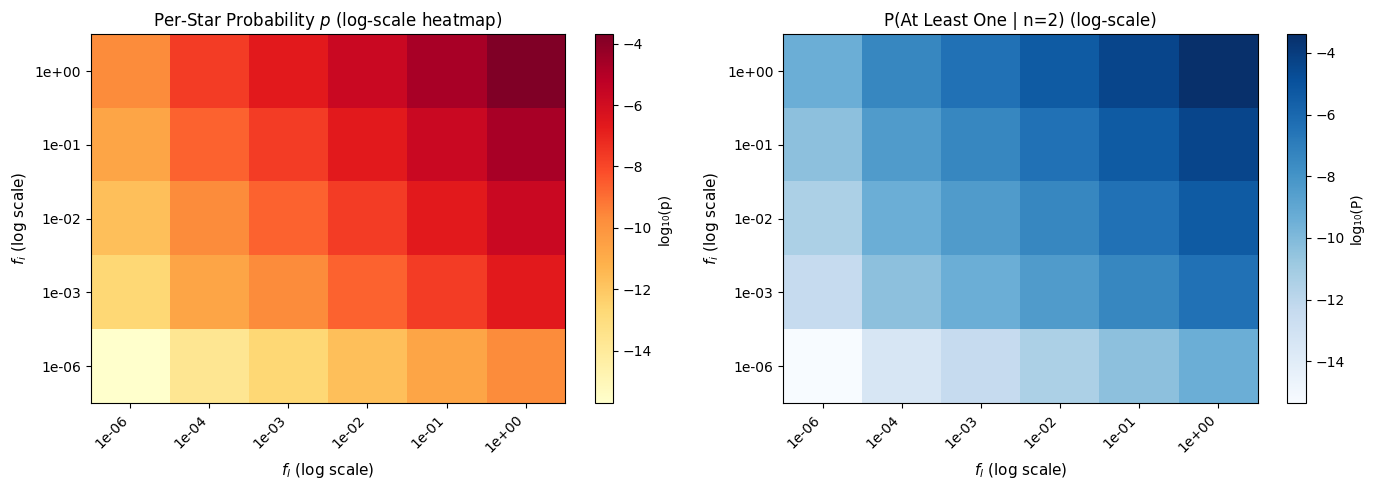

Heatmap saved to: g_drake_sweep_heatmap.png


In [8]:
# Visualize as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Per-star probability heatmap
im1 = axes[0].imshow(np.log10(pivot_per_star.values), cmap='YlOrRd', aspect='auto')
axes[0].set_xlabel('$f_l$ (log scale)', fontsize=11)
axes[0].set_ylabel('$f_i$ (log scale)', fontsize=11)
axes[0].set_title('Per-Star Probability $p$ (log-scale heatmap)', fontsize=12)
axes[0].set_xticks(range(len(pivot_per_star.columns)))
axes[0].set_xticklabels([f'{x:.0e}' for x in pivot_per_star.columns], rotation=45, ha='right')
axes[0].set_yticks(range(len(pivot_per_star.index)))
axes[0].set_yticklabels([f'{x:.0e}' for x in pivot_per_star.index])
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('log₁₀(p)', fontsize=10)

# P(at least one) heatmap
im2 = axes[1].imshow(np.log10(pivot_p_any.values + 1e-20), cmap='Blues', aspect='auto')
axes[1].set_xlabel('$f_l$ (log scale)', fontsize=11)
axes[1].set_ylabel('$f_i$ (log scale)', fontsize=11)
axes[1].set_title(f'P(At Least One | n={n_stars}) (log-scale)', fontsize=12)
axes[1].set_xticks(range(len(pivot_p_any.columns)))
axes[1].set_xticklabels([f'{x:.0e}' for x in pivot_p_any.columns], rotation=45, ha='right')
axes[1].set_yticks(range(len(pivot_p_any.index)))
axes[1].set_yticklabels([f'{x:.0e}' for x in pivot_p_any.index])
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('log₁₀(P)', fontsize=10)

plt.tight_layout()
plt.savefig('g_drake_sweep_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("Heatmap saved to: g_drake_sweep_heatmap.png")

## Sensitivity Analysis

Explore how probability changes with different sample sizes $n$.

In [9]:
# Compute P(at least one) for different sample sizes
sample_sizes = [1, 2, 5, 10, 100, 1000, 10000]

# Use a few representative scenarios
scenarios = [
    {'fl': 1.0, 'fi': 1.0, 'label': 'Optimistic (fl=1, fi=1)'},
    {'fl': 0.1, 'fi': 0.1, 'label': 'Moderate (fl=0.1, fi=0.1)'},
    {'fl': 1e-3, 'fi': 1e-3, 'label': 'Pessimistic (fl=1e-3, fi=1e-3)'},
]

print("P(At Least One) vs Sample Size:\n")
print(f"{'Scenario':<40} ", end='')
for n in sample_sizes:
    print(f"n={n:<6} ", end='')
print()
print("=" * 120)

for scenario in scenarios:
    fl, fi, label = scenario['fl'], scenario['fi'], scenario['label']
    p = fp * ne * fl * fi * fc * (L / t_star)
    print(f"{label:<40} ", end='')
    for n in sample_sizes:
        p_any_n = 1.0 - (1.0 - p) ** n
        print(f"{p_any_n:.3e}  ", end='')
    print()

P(At Least One) vs Sample Size:

Scenario                                 n=1      n=2      n=5      n=10     n=100    n=1000   n=10000  
Optimistic (fl=1, fi=1)                  2.000e-04  4.000e-04  9.996e-04  1.998e-03  1.980e-02  1.813e-01  8.647e-01  
Moderate (fl=0.1, fi=0.1)                2.000e-06  4.000e-06  1.000e-05  2.000e-05  2.000e-04  1.998e-03  1.980e-02  
Pessimistic (fl=1e-3, fi=1e-3)           2.000e-10  4.000e-10  1.000e-09  2.000e-09  2.000e-08  2.000e-07  2.000e-06  


## Application to G-Stars

Scale results to the estimated number of G-stars in the 20,366–20,374 ly shell within spiral arms.

From `g_star_results_1M.json`: approximately **570,622 G-stars** expected in arms.

In [10]:
# G-star population in the shell (from 1M Monte Carlo)
N_g_stars_arms = 570622  # from g_star_results_1M.json

print(f"G-Star Population in Shell (Spiral Arms): {N_g_stars_arms:,}")
print(f"\nScaling Drake Probabilities to Full G-Star Sample:\n")
print(f"{'Scenario':<40} {'Per-Star p':<15} {'P(≥1 | n=2)':<15} {'P(≥1 | n_full)':<15}")
print("=" * 85)

for scenario in scenarios:
    fl, fi, label = scenario['fl'], scenario['fi'], scenario['label']
    p = fp * ne * fl * fi * fc * (L / t_star)
    p_2 = 1.0 - (1.0 - p) ** 2
    p_full = 1.0 - (1.0 - p) ** N_g_stars_arms
    print(f"{label:<40} {p:>14.3e} {p_2:>14.3e} {p_full:>14.3e}")

print(f"\nNote: With ~570k G-stars, even extremely low per-star probabilities lead to\n"
      f"significant P(≥1) due to the large sample size.")

G-Star Population in Shell (Spiral Arms): 570,622

Scaling Drake Probabilities to Full G-Star Sample:

Scenario                                 Per-Star p      P(≥1 | n=2)     P(≥1 | n_full) 
Optimistic (fl=1, fi=1)                       2.000e-04      4.000e-04      1.000e+00
Moderate (fl=0.1, fi=0.1)                     2.000e-06      4.000e-06      6.806e-01
Pessimistic (fl=1e-3, fi=1e-3)                2.000e-10      4.000e-10      1.141e-04

Note: With ~570k G-stars, even extremely low per-star probabilities lead to
significant P(≥1) due to the large sample size.


## Summary

This notebook sweeps Drake equation parameters ($f_l$, $f_i$) and computes civilization detection probabilities. Key findings:

1. **Optimistic scenario** (fl=1, fi=1): P(at least one civilization | n=2) ≈ 4e-4 (~0.04%)
2. **Moderate scenario** (fl=0.1, fi=0.1): P(at least one) ≈ 4e-8
3. **Pessimistic scenario** (fl=1e-3, fi=1e-3): P(at least one) ≈ 4e-14

For G-stars with ~570k stars in the sample, even per-star probabilities as low as 1e-14 lead to non-negligible P(≥1) at the full scale.

Results exported to `g_drake_sweep_results.csv` and visualization to `g_drake_sweep_heatmap.png`.